# Tutorial IV: Convolutions

<p>
Bern Winter School on Machine Learning, 28.01-01.02 2019<br>
Mykhailo Vladymyrov
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will look at the convolutoin operation and try to build some intuition about it.
Also we will look at one of the state-of-the art deep models, [Inception](https://arxiv.org/abs/1602.07261). It is designed to perform image recognition.

## unpack libraries
if using colab, upload the `material.tgz` and run the next cell

In [ ]:
!tar -xvzf material.tgz

## 1. Load necessary libraries

In [ ]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
from PIL import Image

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')
from utils import gr_disp
from utils import inception

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

## 2. Convolutions

In fully connected network all inputs are cnnected to all neurons of next layer:
<tr>
    <td> 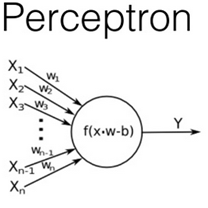</td> 
    <td> 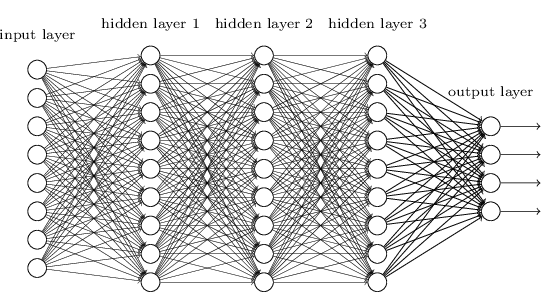</td> 
</tr> 
<br>In convolutional nets the same holds for each neighbourhood, and the weights are shared:<br>
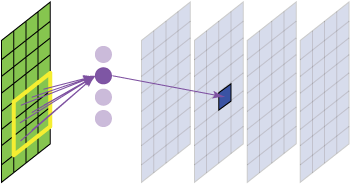<br>
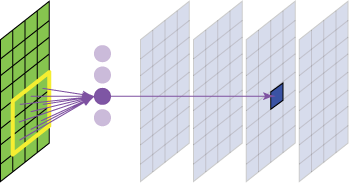<br>
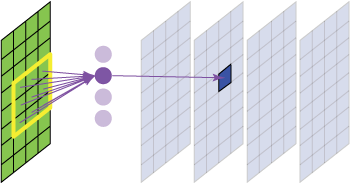

Let's see what a convolution is, and how it behaves.

In [ ]:
#load image, convert to gray-scale and normalize
img_raw = plt.imread('ML3/chelsea.jpg').mean(axis=2)[-256:, 100:356].astype(np.float32)
img_raw = (img_raw-img_raw.mean())/img_raw.std()

plt.imshow(img_raw, cmap='gray')
plt.grid(False)
img_raw4d = img_raw[np.newaxis,...,np.newaxis]

In [ ]:
g = tf.Graph()
with g.as_default():
    #convolve x 5 times with a 5x5 filter
    x = tf.placeholder(dtype=tf.float32, shape=(1,256,256,1),name='img')
    flt = tf.placeholder(dtype=tf.float32, shape=(5,5,1,1), name='flt')
    y1 = tf.nn.conv2d(x , flt, strides=[1,1,1,1], padding='VALID', name='convolved') #[1,2,2,1]
    y2 = tf.nn.conv2d(y1, flt, strides=[1,1,1,1], padding='VALID', name='convolved')
    y3 = tf.nn.conv2d(y2, flt, strides=[1,1,1,1], padding='VALID', name='convolved')
    y4 = tf.nn.conv2d(y3, flt, strides=[1,1,1,1], padding='VALID', name='convolved')
    

In [ ]:
flt_mtx = [
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 1, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
]
with tf.Session(graph=g) as sess:
    flt_mtx_np = np.array(flt_mtx, np.float32)
    flt_mtx_np = flt_mtx_np[..., np.newaxis, np.newaxis]
    res = sess.run([x,y1,y2,y3,y4], feed_dict={x:img_raw4d, flt:flt_mtx_np})
res = [r[0,...,0] for r in res]
n = len(res)
fig, ax = plt.subplots(1, n, figsize=(n*4, 4))
for col in range(n):
    ax[col].imshow(res[col], cmap='gray')
    ax[col].grid(False)

In [ ]:
def conv_2D(x, n_output_ch,
            k_w=3, k_h=3,
            s_x=1, s_y=1,
            activation=tf.nn.relu,
            padding='VALID', name='conv2d', reuse=None
           ):
    """
    Helper for creating a 2d convolution operation.

    Args:
        x (tf.Tensor): Input tensor to convolve.
        n_output_ch (int): Number of filters.
        k_w (int): Kernel width
        k_h (int): Kernel height
        s_x (int): Width stride
        s_y (int): Height stride
        activation (tf.Function): activation function to apply to the convolved data
        padding (str): Padding type: 'SAME' or 'VALID'
        name (str): Variable scope
        reuse (tf.Flag): Flag whether to use existing variable. Can be False(None), True, or tf.AUTO_REUSE

    Returns:
        op (tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor): Output of activation, convolution, weights, bias
    """
    with tf.variable_scope(name or 'conv2d', reuse=reuse):
        w = tf.get_variable(name='W',
                            shape=[k_h, k_w, x.get_shape()[-1], n_output_ch],
                            initializer=tf.contrib.layers.xavier_initializer()
                           )
        
        wx = tf.nn.conv2d(name='conv',
                          input=x, filter=w,
                          strides=[1, s_y, s_x, 1],
                          padding=padding
                         )
        
        b = tf.get_variable(name='b',
                            shape=[n_output_ch], initializer=tf.constant_initializer(value=0.0)
                           )
        h = tf.nn.bias_add(name='h',
                           value=wx,
                           bias=b
                          )

        if activation is not None:
            x = activation(h, name=activation.__name__)
        else:
            x = h
    
    return x, h, w, b

## 3. Load the model

inception module here is a small module that performs loading the inception model as well as image preparation for the training.

In [ ]:
net, net_labels = inception.get_inception_model()

In [ ]:
#get model graph definition and change it to use GPU
gd = net

str_dg = gd.SerializeToString()
#uncomment next line to use GPU acceleration
#str_dg = str_dg.replace(b'/cpu:0', b'/gpu:0') #a bit extreme approach, but works =)
gd = gd.FromString(str_dg)

gr_disp.show(gd)

## 4. Create the graph

This whole model won't fit in GPU memory. We will take only the part from input to the main output and copy it to a second graph, that we will use further.

In [ ]:
gd2 = tf.graph_util.extract_sub_graph(gd, ['output'])
g2 = tf.Graph() # full graph
with g2.as_default():
    tf.import_graph_def(gd2, name='inception')

gr_disp.show(g2.as_graph_def())

## 5. Test the model

We will use one image to check model. `img_preproc` is croped to 256x256 pixels and slightly transformed to be used as imput for the model using `inception.prepare_training_img`. `inception.training_img_to_display` is then used to convert it to displayable one.


In [ ]:
img_raw = plt.imread('ML3/chelsea.jpg')
img_preproc = inception.prepare_training_img(img_raw)
img_deproc = inception.training_img_to_display(img_preproc)
_, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img_raw)
axs[0].grid(False)
axs[1].imshow(img_deproc)
axs[1].grid(False)
plt.show()

We then get the input and output tensors, and obtain probabilities of each class on this image:

In [ ]:
#from graph we will get the input and output tensors. 
#Any tensor and operation can be obtained by name
g2.device('/gpu:0')
with g2.as_default():
    x = g2.get_tensor_by_name('inception/input:0')
    softmax = g2.get_tensor_by_name('inception/output:0')
    
#Then we will feed the image in the graph and print 5 classes that have highest probability
with tf.Session(graph=g2) as sess:
    res = np.squeeze(sess.run(softmax, feed_dict={x: img_preproc[np.newaxis]}))
    
    indexes_sorted_by_probability = res.argsort()[::-1]
    print([(res[idx], net_labels[idx])
           for idx in indexes_sorted_by_probability[:5]])